<b>Quantum Phase Estimation</b>

In this notebook we will introduce the Phase Estimation Algorithm, that is part of many important algorithms in Quantum Computing, such as Shor's algorithm, and also uses the Quantum Fourier Transform we saw in last notebook to take part into the process of what Phase Estimation does. As the name of the algorithm suggests, it is used to estimate the phase of an operator/function called U, so: $U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$, where θ is the phase we want to estimate.  
  
First, we will take a look at a representation of the circuit that does the Phase Estimation:  
  
<img src="https://qiskit.org/textbook/ch-algorithms/images/qpe_tex_qz.png">

Here we have the first register, that will act as a counter, and on which we will store 2^nθ. The last qubit is in the second register, and it is used to support the QFT operation that is being done at first part.  
  
First of all, we will apply a Hadamart gate to all qubits of the first register, and then we will do Controlled-U operations for every qubit that is in the first register: qubits in first register will act as the control qubit, and the last qubit of the second register will act as the target qubit. Note that this process is the same as what we were doing when developing the QFT algorithm. (Controlled-U is a custom gate that has a control qubit and does the Unitary Operation we specify on the target qubit if control qubit is 1)  
  
Then, we will have to undo the QFT operation by doing the inverse of QFT. This will give us the phase estimation of the Unitary Operator in a computational basis, because first we go to Fourier basis, and this gives us the phase, but we have to return to computational basis to measure the result.

As a example to develop the circuit in Python and to understand the algorithm clearly, without a lot of details that can be difficult to understand, we will suppose that our Unitary Operator is the T-Gate, a gate that adds a phase of $e^\frac{i\pi}{4}$ to the state |1>. Since QPE gives us θ where: $T|1\rangle = e^{2i\pi\theta}|1\rangle$, we derive that $\theta = \frac{1}{8}$, the result we expect to find. We will use 3 qubits to obtain the exact result, not an estimation.  
  
So, we will start by importing the packages we will need to develop the code, and then we will create the circuit and place all gates we need.

In [23]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram
import numpy as np
from math import pi

We will put the last qubit in state |1> because T-Gate has to add the phase to state |1>, as we mentioned above. Then, we will apply Hadamart gates.

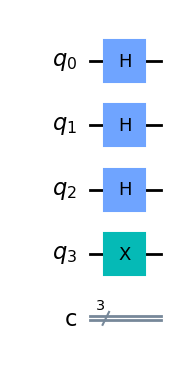

In [24]:
qpe = QuantumCircuit(4,3)
qpe.x(3)
qpe.h([0,1,2])
qpe.draw(output='mpl')

Next we perform Unitary Operation, the T-Gate. Remember that we have to place the U-Controlled gates in inverse order, because first qubit is the least significant qubit in Qiskit, and in the representation we saw above is the last, and we only have to apply 2^0 = 1 times the T-Controlled gate.

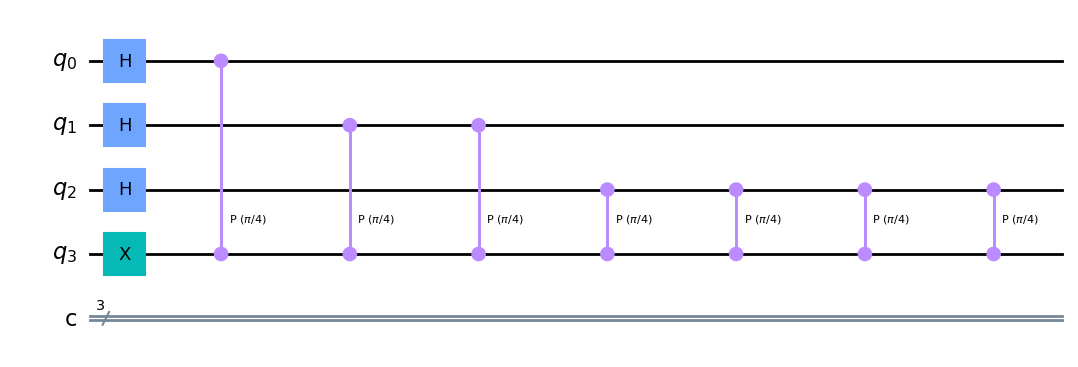

In [25]:
'''apply cp to rotate last qubit by pi/4 full turn'''
qpe.cp(pi/4, 0, 3)
qpe.cp(pi/4, 1, 3)
qpe.cp(pi/4, 1, 3)
qpe.cp(pi/4, 2, 3)
qpe.cp(pi/4, 2, 3)
qpe.cp(pi/4, 2, 3)
qpe.cp(pi/4, 2, 3)
qpe.draw(output='mpl')

And, finally, we have to put the inverse of QFT on first register (all qubits except last). We will reuse the code of the circuit we did in last notebook, and we only will have to call inverse() and append it to the actual circuit. Then we will measure all qubits except last (first register, our counter)

In [26]:
def qft_circuit():
    qft = QuantumCircuit(3)

    qft.h(2)
    qft.cp(pi/2, 1, 2)
    qft.cp(pi/4, 0, 2)

    qft.h(1)
    qft.cp(pi/2, 0, 1)

    qft.h(0)

    qft.swap(0,2)

    return qft

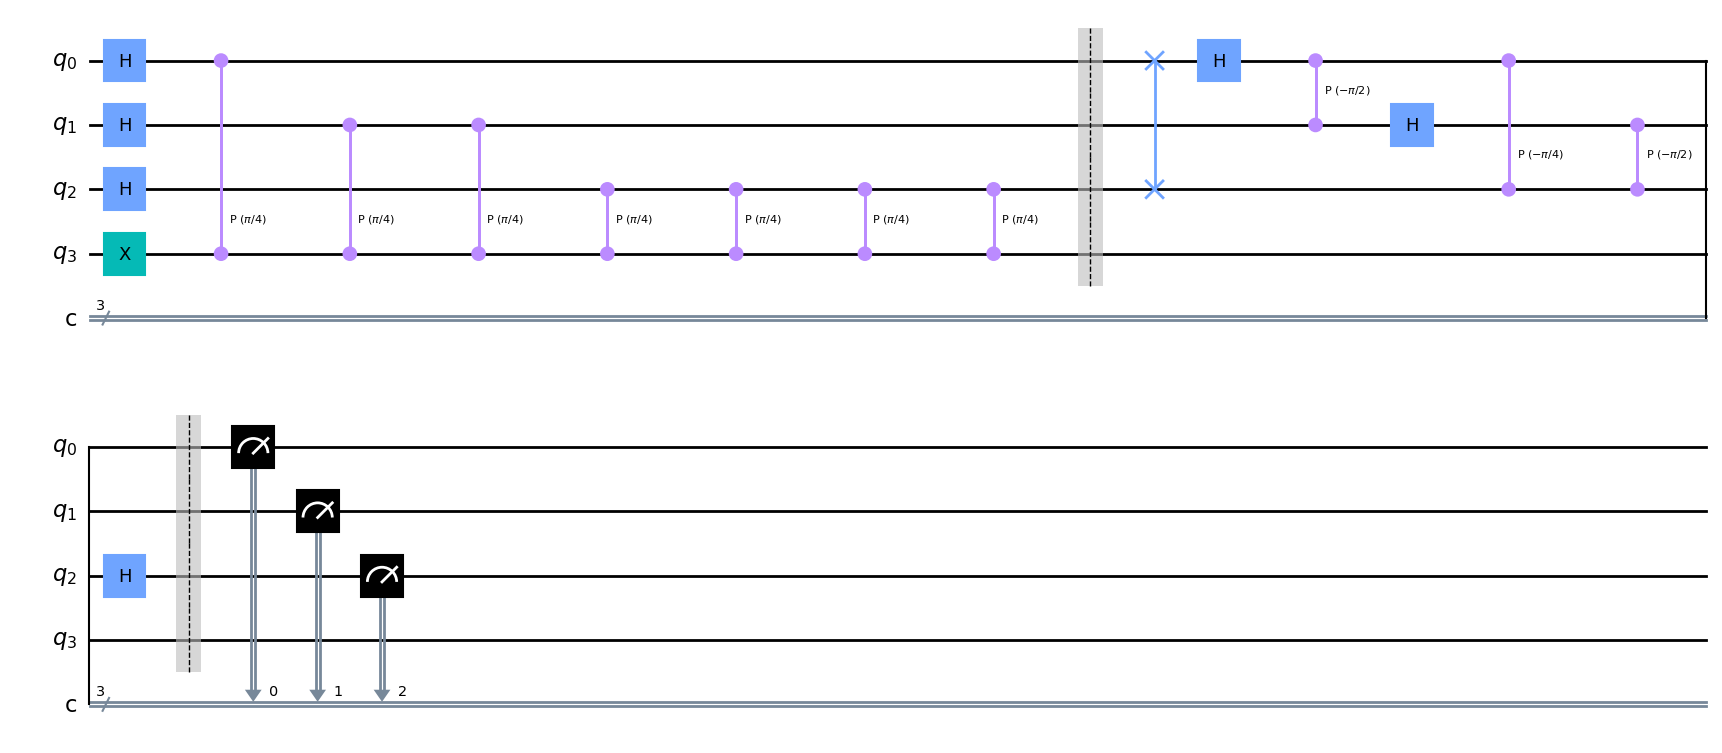

In [27]:
qpe.barrier()

qft = qft_circuit()
qft_inv = qft.inverse()
qpe = qpe.compose(qft_inv)

qpe.barrier()
qpe.measure([0,1,2], [0,1,2])

qpe.draw(output='mpl')

It's time to execute the circuit on simulator and see the results!

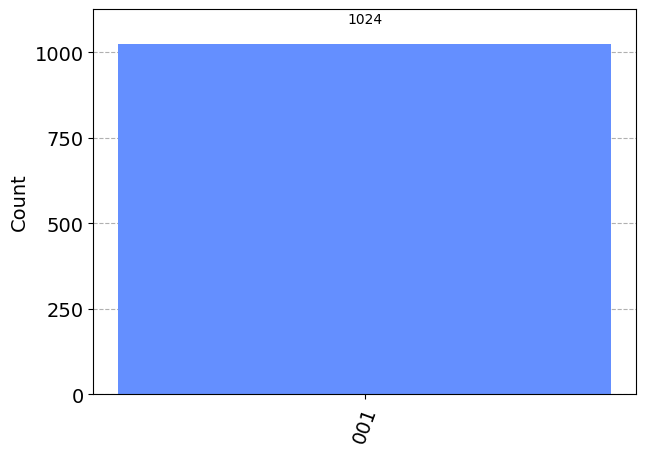

In [28]:
simulator = Aer.get_backend('aer_simulator')
qobj = assemble(qpe)
histogram = simulator.run(qobj).result().get_counts()
plot_histogram(histogram)

We obtain a 001, that in decimal is the number 1. Remember that $\theta = \frac{x}{2^n}$, where x is the result we obtain from the execution (in our case we obtained 1), and n is the number of qubits we have in first register (in our case 3).  
So, we have that $\theta = \frac{1}{2^3} = \frac{1}{8}$, and this is the phase we expected to obtain! So circuit works correctly.
  
As a final conclusion, if we have a more difficult problem, that we can only get a phase estimation instead of an exact phase (that are most of the cases), we can get more precision on the result while more qubits we add to the circuit. Larger number of qubits gives us more precision, because of the definition of $\theta$ we have seen above ($\theta = \frac{x}{2^n}$).